In [1]:
#MOUNTING GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/gdrive',  force_remount=True) 

# force_remount is an argument to force google drive to mount once again.

Mounted at /content/gdrive


In [2]:

from PIL import Image
import pathlib
import csv
import os
# sklearn Preprocessing
from sklearn.model_selection import train_test_split
#Keras
import keras
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD
 
from keras.preprocessing.image import ImageDataGenerator


In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255, # rescale all pixel values from 0-255, so aftre this step all our pixel values are in range (0,1)
        shear_range=0.2, # to apply some random tranfromations
        zoom_range=0.2, # to apply zoom
        horizontal_flip=True) # image will be flipper horizontally
test_datagen = ImageDataGenerator(rescale=1./255)
 
 
training_set = train_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/bird_call_identification/data_new/train',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False,)
test_set = test_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/bird_call_identification/data_new/val',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False )

Found 158 images belonging to 10 classes.
Found 40 images belonging to 10 classes.


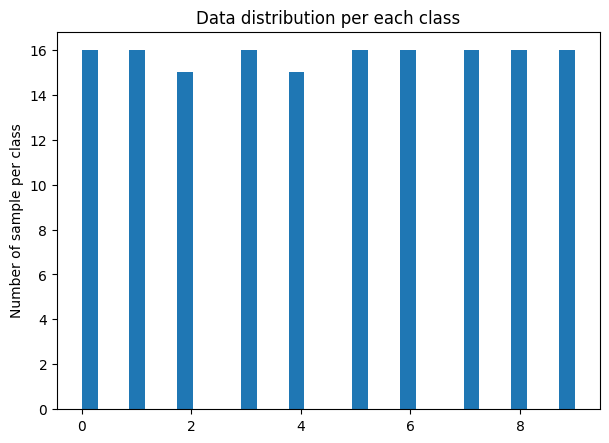

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({
    'figure.figsize':(7,5), 
    'figure.dpi':100
})

# Plot Histogram 
plt.hist(training_set.classes, bins=31)
plt.gca().set(title='Data distribution per each class', ylabel='Number of sample per class');

In [5]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
# reduces learning rate if no improvement are seen
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=1,
                                            verbose=0,
                                            factor=0.2,
                                            min_lr=0.000001)

# stop training if no improvements are seen
early_stop = EarlyStopping(monitor="val_loss",
                            mode="min",
                            patience=3,
                            restore_best_weights=True)

# saves model weights to file
checkpoint = ModelCheckpoint(os.path.join('/content/gdrive/MyDrive/bird_call_identification/model', 'cp-{epoch:04d}.h5'),
                            monitor='val_loss',
                            verbose=0,
                            save_best_only=True,
                            mode='min',
                            save_weights_only=True)

In [6]:
model = Sequential()
input_shape=(64, 64, 3)

#1st hidden layer
model.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

#2nd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

#3rd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

#Flatten
model.add(Flatten())
model.add(Dropout(rate=0.5))

#Add fully connected layer.
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.4))

#Output layer
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()
 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 32)       0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 7, 7, 64)         0         
 ePooling2D)                                                     
                                                                 
 activation_1 (Activation)   (None, 7, 7, 64)          0

In [7]:
epochs =2500
batch_size = 8
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=['accuracy'])

In [8]:
model.fit(
        training_set,
                batch_size=8,
        epochs=2500,
        validation_data=test_set,
        validation_steps=25)
model.save('model2.h5')

Epoch 1/2500
5/5 [==============================] - ETA: 0s - loss: 2.3113 - accuracy: 0.1139

5/5 [==============================] - 6s 666ms/step - loss: 2.3113 - accuracy: 0.1139 - val_loss: 2.3037 - val_accuracy: 0.1000
Epoch 2/2500
5/5 [==============================] - 2s 304ms/step - loss: 2.3136 - accuracy: 0.0823
Epoch 3/2500
5/5 [==============================] - 2s 295ms/step - loss: 2.3134 - accuracy: 0.0759
Epoch 4/2500
5/5 [==============================] - 2s 303ms/step - loss: 2.3055 - accuracy: 0.1139
Epoch 5/2500
5/5 [==============================] - 2s 319ms/step - loss: 2.3105 - accuracy: 0.0759
Epoch 6/2500
5/5 [==============================] - 2s 320ms/step - loss: 2.3080 - accuracy: 0.1203
Epoch 7/2500
5/5 [==============================] - 2s 308ms/step - loss: 2.3082 - accuracy: 0.0823
Epoch 8/2500
5/5 [==============================] - 2s 296ms/step - loss: 2.3148 - accuracy: 0.0443
Epoch 9/2500
5/5 [==============================] - 2s 299ms/step - loss: 2.3046 - accuracy: 0.0949
Epoch 10/2500
5/5 [==============================] - 2s 296ms/step - lo

In [9]:
import numpy as np
test_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/bird_call_identification/data_new/train',
        target_size=(64,64),
        batch_size=20,
        class_mode='categorical',
        shuffle=False)
pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=0)
# Get classes by max element in np (as a list)
classes = list(np.argmax(pred, axis=1))
# Get filenames (set shuffle=false in generator is important)
filenames = test_generator.filenames
for f in zip(classes, filenames):
  print(f)


Found 158 images belonging to 10 classes.
(0, 'Black Redstart/Phoenicurusochruros100012.png')
(0, 'Black Redstart/Phoenicurusochruros110687.png')
(0, 'Black Redstart/Phoenicurusochruros110688.png')
(0, 'Black Redstart/Phoenicurusochruros132603.png')
(0, 'Black Redstart/Phoenicurusochruros174249.png')
(0, 'Black Redstart/Phoenicurusochruros310132.png')
(0, 'Black Redstart/Phoenicurusochruros311594.png')
(0, 'Black Redstart/Phoenicurusochruros327883.png')
(0, 'Black Redstart/Phoenicurusochruros346213.png')
(0, 'Black Redstart/Phoenicurusochruros346214.png')
(0, 'Black Redstart/Phoenicurusochruros93473.png')
(0, 'Black Redstart/Phoenicurusochruros93474.png')
(0, 'Black Redstart/Phoenicurusochruros93475.png')
(0, 'Black Redstart/Phoenicurusochruros93480.png')
(0, 'Black Redstart/Phoenicurusochruros93481.png')
(0, 'Black Redstart/Phoenicurusochruros93484.png')
(1, 'Chestnut-collared Swift/XC125663 - Chestnut-collared Swift - Streptoprocne rutila brunnitorques.png')
(1, 'Chestnut-collared Sw

In [14]:
!pip install soundfile
import soundfile
import matplotlib.pyplot as plt
import numpy as np
import librosa
from librosa.display import specshow
import os
import keras.utils as image

#converting to spectrogram
path="/content/gdrive/MyDrive/bird_call_identification/XC261705 - White-tipped Sicklebill - Eutoxeres aquila heterurus.wav"
audio_signal, sampling_rate = soundfile.read(path)
window_length = int(0.025 * sampling_rate)
hop_length = int(0.01 * sampling_rate)
spectrogram = np.abs(librosa.stft(audio_signal, hop_length=hop_length, win_length=window_length))
specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),sr=sampling_rate,hop_length=hop_length,)
plt.savefig(path.replace("wav", "png"), bbox_inches="tight", pad_inches=0)
plt.close()

from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# dimensions of our images
img_width, img_height = 64,64

# load the model we saved
model = load_model('/content/model2.h5')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# predicting images
img = image.load_img(path.replace("wav","png"), target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
predict_x = model.predict(images) 
classes = np.argmax(predict_x,axis=1)
# classes = model.predict_classes(images, batch_size=10)
print(classes)
a=["Black Redstart","Chestnut-collared Swift","Eurasian Nuthatch","European Greenfinch","Greater Rhea","Indian Spot-billed Duck","Southern Cassowary","Surf Scoter","Swallow-tailed Nightjar","White-tipped Sicklebill"]
print(a[classes[0]])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
1/1 [==============================] - 0s 115ms/step
[9]
White-tipped Sicklebill


In [15]:
#converting to spectrogram
path="/content/gdrive/MyDrive/bird_call_identification/Chlorischloris121007.wav"
audio_signal, sampling_rate = soundfile.read(path)
window_length = int(0.025 * sampling_rate)
hop_length = int(0.01 * sampling_rate)
spectrogram = np.abs(librosa.stft(audio_signal, hop_length=hop_length, win_length=window_length))
specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),sr=sampling_rate,hop_length=hop_length,)
plt.savefig(path.replace("wav", "png"), bbox_inches="tight", pad_inches=0)
plt.close()


# dimensions of our images
img_width, img_height = 64,64

# load the model we saved
model = load_model('/content/model2.h5')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# predicting images
img = image.load_img(path.replace("wav","png"), target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
predict_x = model.predict(images) 
classes = np.argmax(predict_x,axis=1)
# classes = model.predict_classes(images, batch_size=10)
print(classes)
a=["Black Redstart","Chestnut-collared Swift","Eurasian Nuthatch","European Greenfinch","Greater Rhea","Indian Spot-billed Duck","Southern Cassowary","Surf Scoter","Swallow-tailed Nightjar","White-tipped Sicklebill"]
print(a[classes[0]])

1/1 [==============================] - 0s 65ms/step
[3]
European Greenfinch
